In [138]:
!pip install lightning
%config IPCompleter.greedy=True

Import biblioteci

In [1]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl
from torch.autograd import Variable
import logging

from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

data_file = 'AAPL_history.csv'
testing_file = 'AAPL_history_test.csv'

torch.set_default_dtype(torch.float64)

In [140]:
NUM_EPOCHS = 100

Citire date

In [141]:
data = pd.read_csv(data_file)
print(data)

                          Date        Open        High         Low  \
0    2022-01-03 00:00:00-05:00  176.052746  181.052279  175.933951   
1    2022-01-04 00:00:00-05:00  180.804778  181.111677  177.329848   
2    2022-01-05 00:00:00-05:00  177.814959  178.369360  172.894629   
3    2022-01-06 00:00:00-05:00  170.974007  173.548028  169.924603   
4    2022-01-07 00:00:00-05:00  171.162131  172.399639  169.320719   
..                         ...         ...         ...         ...   
246  2022-12-23 00:00:00-05:00  130.363811  131.857438  129.089250   
247  2022-12-27 00:00:00-05:00  130.821856  130.851727  128.173153   
248  2022-12-28 00:00:00-05:00  129.119123  130.473346  125.335271   
249  2022-12-29 00:00:00-05:00  127.446252  129.925671  127.187362   
250  2022-12-30 00:00:00-05:00  127.864474  129.397925  126.888634   

          Close     Volume  Dividends  Stock Splits  
0    180.190964  104487900        0.0           0.0  
1    177.904053   99310400        0.0           0.0

Date antrenament + feature-uri

In [142]:
training_data = data[data.columns[1:6]]
print(training_data)

           Open        High         Low       Close     Volume
0    176.052746  181.052279  175.933951  180.190964  104487900
1    180.804778  181.111677  177.329848  177.904053   99310400
2    177.814959  178.369360  172.894629  173.171829   94537600
3    170.974007  173.548028  169.924603  170.281006   96904000
4    171.162131  172.399639  169.320719  170.449326   86709100
..          ...         ...         ...         ...        ...
246  130.363811  131.857438  129.089250  131.299820   63814900
247  130.821856  130.851727  128.173153  129.477585   69007800
248  129.119123  130.473346  125.335271  125.504547   85438400
249  127.446252  129.925671  127.187362  129.059372   75703700
250  127.864474  129.397925  126.888634  129.378006   77034200

[251 rows x 5 columns]


Definire model

Data load

In [143]:
def sliding_window(data, win_size):
    inputs = []
    labels = []
    data_array = data.numpy()
    
    for i in range(len(data_array) - win_size):
        data_slice_input = data_array[i:i+win_size-1]
        data_slice_label = data_array[i+win_size-1]
        
        inputs.append(data_slice_input)
        labels.append(data_slice_label)
    
    inputs = torch.tensor(np.expand_dims(np.array(inputs), axis=2))
    labels = torch.tensor(np.array(labels))
    return inputs, labels

# Get training data
sc = MinMaxScaler()
training_data = torch.tensor(training_data['Open'])
training_data = training_data.unsqueeze(1).numpy()
training_tensor = torch.tensor(sc.fit_transform(training_data)).view(-1)

# Generate training data
inputs, labels = sliding_window(training_tensor, 5)

# Create dataloader
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)


In [169]:
def map_tensor(fun, data):
    data_mapped = []
    for i in range(len(data)):
        data_mapped.append(fun(torch.tensor([data[i]], dtype=torch.float64)))

    if data_mapped == []:
        return []
    data_out = torch.stack(data_mapped, dim=0)
    
    return data_out

def map_tensor_out(fun, data):
    data_mapped = []
    for i in range(len(data)):
        data_mapped.append(fun(data[i]))

    data_out = torch.stack(data_mapped, dim=0)

    return data_out

def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0.01)

class TestLSTM(pl.LightningModule):
    def __init__(self):
        super().__init__()

        #self.in_layer = nn.Sequential(nn.Linear(1, 5), nn.ReLU(), nn.Linear(5, 5), nn.ReLU())
        #self.out_layer = nn.Sequential(nn.Linear(5, 5), nn.ReLU(), nn.Linear(5, 1), nn.ReLU())
        self.out_layer = nn.Linear(5, 1)
        #self.in_layer.apply(init_weights)
        self.out_layer.apply(init_weights)
    
        self.lstm = nn.LSTM(input_size=1, hidden_size=5)

        self.lr = 0.2
        self.loss_fn = nn.MSELoss()

        self.total_loss = 0

    def forward(self, input):
        lstm_input = input
        h0 = Variable(torch.zeros(
            1, 4, 5))
        
        c0 = Variable(torch.zeros(
            1, 4, 5))
        
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        output = self.out_layer(lstm_out)
        return output

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        input, label = batch
        output = self.forward(input[0])
        loss = self.loss_fn(output[0], label[0])

        self.total_loss += loss

        if batch_idx == 1:
            print('output: ', output)
    
        return loss

    def on_train_epoch_end(self):
        print('total_loss: ', total_loss)
        self.total_loss = 0
        




In [170]:
# Init model
model = TestLSTM()

In [52]:
model = torch.load('model_v2_AAPL')
model.eval()

TestLSTM(
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
  (lstm): LSTM(1, 5)
  (loss_fn): MSELoss()
)

In [35]:
model.load_state_dict(torch.load('model_v1'))
model.eval()

RuntimeError: Error(s) in loading state_dict for TestLSTM:
	Missing key(s) in state_dict: "out_layer.0.weight", "out_layer.0.bias", "out_layer.2.weight", "out_layer.2.bias". 
	Unexpected key(s) in state_dict: "out_layer.weight", "out_layer.bias". 

In [171]:
def apply_model(model, data):
    data_apply = []
    for input in data:
        data_apply.append(model(input)[0])
    return torch.stack(data_apply, dim=0)



pred = model(inputs)

print(pred[0:5])

pred = pred[:, -1, :]
pred = pred.view(-1)
print(pred)
print(labels)

tensor([[[-0.0986],
         [-0.1037],
         [-0.1006],
         [-0.0925]],

        [[-0.1603],
         [-0.1596],
         [-0.1494],
         [-0.1455]],

        [[-0.1876],
         [-0.1783],
         [-0.1735],
         [-0.1661]],

        [[-0.1919],
         [-0.1877],
         [-0.1798],
         [-0.1811]],

        [[-0.1943],
         [-0.1867],
         [-0.1878],
         [-0.1936]]], grad_fn=<SliceBackward0>)
tensor([-0.0925, -0.1455, -0.1661, -0.1811, -0.1936, -0.1990, -0.1953, -0.1940,
        -0.1912, -0.1852, -0.1784, -0.1678, -0.1614, -0.1664, -0.1663, -0.1719,
        -0.1812, -0.1909, -0.1963, -0.1985, -0.1960, -0.1966, -0.1952, -0.2008,
        -0.2006, -0.1980, -0.1893, -0.1910, -0.1929, -0.1925, -0.1905, -0.1819,
        -0.1792, -0.1548, -0.1651, -0.1671, -0.1708, -0.1719, -0.1790, -0.1756,
        -0.1724, -0.1632, -0.1640, -0.1619, -0.1587, -0.1435, -0.1363, -0.1448,
        -0.1505, -0.1563, -0.1639, -0.1705, -0.1773, -0.1851, -0.1928, -0.1938,
    

Model training

In [172]:

model.train()
torch.set_grad_enabled(True)

optimizer = Adam(model.parameters(), lr=0.01)

for epoch in range(500):
    outputs = model(inputs)

    outputs = outputs[:, -1, :]
    outputs = outputs.view(-1)

    loss = model.loss_fn(outputs, labels)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print('loss: ', loss)

#trainer.fit(model, train_dataloaders=dataloader)


loss:  tensor(0.4676, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0220, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0075, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0060, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0052, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0048, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0046, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0044, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0043, grad_fn=<MseLossBackward0>)
loss:  tensor(0.0042, grad_fn=<MseLossBackward0>)


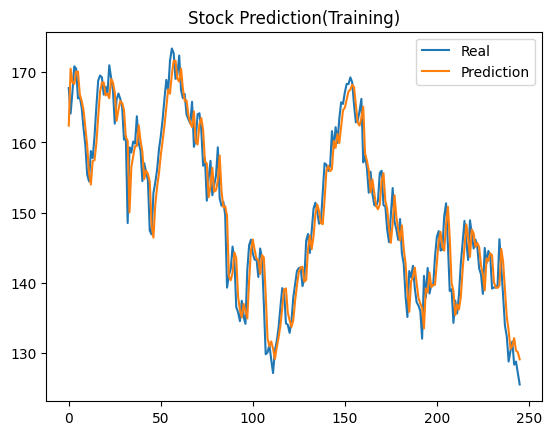

In [173]:
outputs = model(inputs)

outputs = outputs[:, -1, :]
#outputs = outputs.view(-1)

outputs = outputs.detach().numpy()
real = np.expand_dims(labels.numpy(), axis=1)

outputs = sc.inverse_transform(outputs)
real = sc.inverse_transform(real)

plt.plot(real)
plt.plot(outputs)
plt.title('Stock Prediction(Training)')
plt.legend(['Real', 'Prediction'])
plt.show()

In [51]:
# Save Model
torch.save(model, 'model_v2_AAPL')

In [205]:
def unroll_model(model, data, iterations):
    data_unrolled = torch.clone(data).numpy()
    for it in range(iterations):
        #for it in range(iterations):
        model_output = model(torch.tensor(data_unrolled))
    
        model_output = model_output[-1].detach().numpy()
    
        data_unrolled = np.append(data_unrolled, [model_output], axis=0)
    return data_unrolled

def unroll_model_window(model, data, iterations):
    data_unrolled = torch.clone(data[0]).numpy()
    data_window = torch.clone(data).numpy()
    for it in range(iterations):
        model_output = model(torch.tensor(data_window))
        model_output = model_output[0][-1].detach().numpy()

        data_window = np.append(data_window[0][1:len(data_window[0])], [model_output], axis=0)

        data_window = np.array([data_window])
        data_unrolled = np.append(data_unrolled, [model_output], axis=0)
    return data_unrolled

[7.65203255 7.02106073 3.54791762 0.08406287 2.86503847 1.07581203
 1.62681663 2.88471245 0.12243269 2.39560447 2.41635111 0.78783082
 2.14190875 0.27577963 1.68779202 1.94702013 0.81615899 5.18983447
 0.22676751 4.43436891 1.00063897 2.98823502 0.65574004 3.87477072
 0.99046465 1.7918633  1.57700367 0.87310029 0.81987817 2.07826708
 1.38482232 1.36350847 2.34918225 0.39656539 0.22561094 0.02228864
 2.21410856 3.43258462 6.69448607 1.25742475 0.80154046 0.68065799
 2.97009549 2.68660564 3.40043464 0.98194294 1.28934709 4.33512934
 0.00474175 2.28525144 2.63945854 0.23160335 0.24865557 1.41702825
 1.35282781 1.42890086 2.84873944 1.8201733  2.47792907 3.19479781
 0.7453744  2.13191901 1.00867925 1.25203312 0.35255619 0.74667135
 3.55508089 1.70973322 1.73319641 0.51640675 0.84166756 0.35043934
 0.35205995 0.79185082 1.43526009 2.27905566 4.3571203  2.34567072
 1.87385409 0.46638582 3.88268827 5.70394495 3.74756373 2.2388661
 1.3273785  1.989357   1.44804825 0.83541521 0.05488865 0.54193

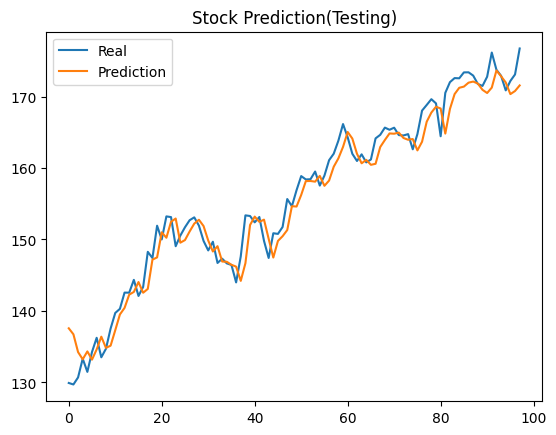

In [209]:
# Test model

# Read all data
full_test_data = pd.read_csv(testing_file)

# Get columns of interest
temp_data = full_test_data[full_test_data.columns[1:6]]

# Get testing data
sc = MinMaxScaler()
temp_data = torch.tensor(temp_data['Open'])
#print(temp_data)
temp_data = temp_data.unsqueeze(1).numpy()
testing_tensor = torch.tensor(sc.fit_transform(temp_data)).view(-1)

#print(testing_tensor)

# Generate testing data
test_inputs, test_labels = sliding_window(testing_tensor, 5)
#print(labels)

test_outputs = model(test_inputs)

test_outputs = test_outputs[:, -1, :]
#outputs = outputs.view(-1)

test_outputs = test_outputs.detach().numpy()
test_real = np.expand_dims(test_labels.numpy(), axis=1)

test_outputs = sc.inverse_transform(test_outputs)
test_real = sc.inverse_transform(test_real)

np.set_printoptions(suppress=True)

print(np.abs(test_real.flatten() - test_outputs.flatten()))
 
plt.plot(range(len(test_real)), test_real)
plt.plot(range(len(test_real)), test_outputs)
plt.title('Stock Prediction(Testing)')
plt.legend(['Real', 'Prediction'])
plt.show()

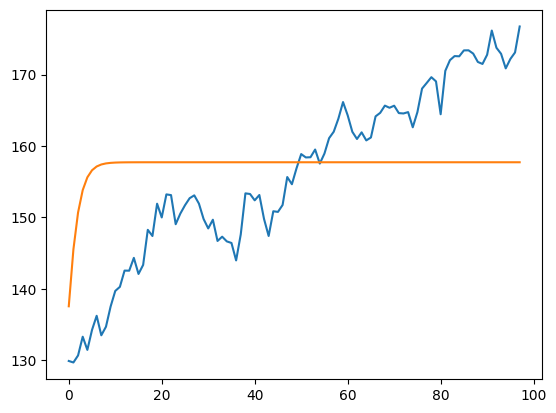

In [210]:
#print(test_inputs[0:1])
data_unrolled = unroll_model_window(model, test_inputs[0:1], len(test_labels))

data_unrolled = data_unrolled[len(test_inputs[0]):len(data_unrolled)]

#print(data_unrolled)

test_labels = np.expand_dims(test_labels, axis=1)

data_unrolled = sc.inverse_transform(data_unrolled)
test_labels = sc.inverse_transform(test_labels)

plt.plot(test_labels)
plt.plot(data_unrolled)
plt.show()